<h1>Scripting NEURON basics</h1>

The objectives of this part of the tutorial are to get familiar with basic operations of NEURON using Python. In this worksheet we will:

* Create a passive cell membrane in NEURON.
* Create a synaptic stimulus onto the neuron.
* Modify parameters of the membrane and stimulus.
* Visualize results with bokeh.

<h2>What is NEURON?</h2>

The NEURON simulation environment is a powerful engine for performing simulations of neurons and biophysical neural networks. It permits the construction of biologically realistic membranes with active and passive ion channels, combined with virtual connectivity and electrophysiology tools to drive and measure neuron and network behaviors.

<h2>Step 1: Import the <tt>neuron</tt> module into Python</h2>

Any code that is not part of Python's <a class="reference external" href="https://docs.python.org/3/library/functions.html#built-in-funcs" title="(in Python v3.6)"><span>Built-in Functions</span></a> must be imported. The Python interface to NEURON goes through the <tt>neuron</tt> module, especially the <tt>neuron.h</tt> submodule. The <tt>neuron</tt> module has additional submodules, including <tt>neuron.rxd</tt> for reaction-diffusion dynamics, <tt>neuron.gui2</tt> for Jupyter-compatible PlotShape graphs, and <tt>neuron.gui</tt> for Interviews-based GUI tools. The <tt>neuron.h</tt> submodule also allows loading files, executing code, and calling functions written in HOC, an older scripting language supported by NEURON. This allows the continued use of HOC libraries in Python code.

To import <tt>neuron</tt>, we <i>could</i> use:

In [1]:
import neuron

If the above succeeded, it produces no output (in recent versions of NEURON), so how can we know what version of NEURON we have? Simple: ask for the `__version__`:

In [2]:
print(neuron.__version__)

7.7.2


There are only a limited number of functions avaiable directly from the <tt>neuron</tt> module. In practice, we usually want to directly import the submodules we need; i.e. <b>do something like the below instead</b>:

In [3]:
from neuron import h

When using NEURON, you will always want the <tt>h</tt> submodule. You may or may not need to import the additional submodules mentioned above. If you do, they can be imported separately or loaded in one line with a comma separated list, as in:

In [4]:
from neuron import h, rxd

NB: When importing <tt>h</tt>, etc like this, there is usually no need for importing <tt>neuron</tt> separately.

<p>NEURON assumes certain default units (concentration in mM, time in ms, voltage in mV), but units can be specified explicitly by importing unit definitions from <tt>neuron.units</tt>. Even if you are using the default units, being explicit makes your code more readable by others. For example:</p>

In [5]:
from neuron.units import ms, mV

If the above gives you an error, then you are using a version of NEURON older than 7.7. Update before proceeding.

<h2>Step 2: Create a cell</h2>

A <a class="reference external" href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html#geometry" title="(in NEURON v7.5)"><span class="xref std std-ref">Section</span></a> is the basic morphological building-block in NEURON. We typically think of a Section as an unbranched cable, but it can also be used to represent a soma. Thus a simple model neuron with only a soma can be created as in:

In [6]:
soma = h.Section(name='soma')

There is no output, so how can we tell that we successfully created a Section?

<h3>Aside 1: NEURON's <tt>h.topology</tt> function</h3>

<p>NEURON's <tt>h.topology()</tt> function displays the topological structure of the entire model, indicating which sections are connected to which sections, where they are connected, and how many <i>segments</i> each section is divided into.</p>
<p>If you're following along with our example, there's not much to see yet since there is only one section, but it does demonstrate that the soma has been created and has one segment (one dash is shown):</p>

In [7]:
h.topology()


|-|       soma(0-1)



1.0

The <tt>h.topology()</tt> function displays its data to screen and returns <tt>1.0</tt> indicating success (this function always succeeds). Note: This function is only for displaying data; other methods must be used to store the data in a variable for programmatic analysis.

<h3>Aside 2: The <tt>psection</tt> method</h3>

<p>Every NEURON section has a <tt>psection</tt> method (think: <b>p</b>roperties of the <b>section</b>) that returns a Python dictionary providing a structured data representation of the properties of the section.</p><p>For example, we can query the soma via:</p>

In [8]:
soma.psection()

{'point_processes': {},
 'density_mechs': {},
 'ions': {},
 'morphology': {'L': 100.0,
  'diam': [500.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x7f8ab0ab0000',
 'cell': None}

The results tell us the soma is a cylinder with length 100 microns, diameter 500 microns, axial resistivity 35.4 ohm*cm, and specific membrance capacitance 1 μF/cm<sup>2</sup>.

<b>Note:</b> calling this method does not itself print anything to the screen. Instead it returns a dictionary. We see the contents of the dictionary only because we are running interactively; from a script, nothing would be printed unless we explicitly printed it with <tt>print</tt>, or, better pretty-printed it with <tt>pprint.pprint</tt>.

Since this is a dictionary, we can extract any properties we want using square brackets. For example, the length of the section is:

In [9]:
soma.psection()['morphology']['L']

100.0

All of these values can be individually accessed in more efficient ways, but <tt>psection</tt> provides an overview of the full properties of the section.

For example, the length of the <tt>soma</tt> is more efficiently available (and settable) via:

In [10]:
soma.L

100.0

<tt>soma.psection()['morphology']['diam']</tt> is a list (of length 1 here), with each entry corresponding to the value for each segment. Similarly for <tt>soma.psection()['cm']</tt>, etc.

<b>Important:</b> You may have noticed that the default diameter is 500 μm, which is excessively large for mammalian neurons. It's the default because it's appropriate for the squid giant axons studied by Hodgkin and Huxley. NEURON also uses squid-relevant values for axial resistivity (<tt>soma.Ra</tt>) and temperature (<tt>h.celsius</tt>). These should all be adjusted for mammalian models.

<h2>Step 3: Set the cell's morphological properties</h2>

Since we're simulating a soma, the default length of 100 μm and diameter of 500 μm are inappropriate. Let's set the length (<tt>L</tt>) and diameter (<tt>diam</tt>) to 20 μm instead:

In [11]:
soma.L = 20
soma.diam = 20

In many models, you will have cells consisting of many connected sections. In brief, this can be done using the Section's <tt>connect</tt> method. That will be described in a subsequent part of the tutorial. For now though, we consider only the soma.

<h3>Aside 3: Python's <tt>dir</tt> function</h3>

We can also probe objects with Python’s built-in <a class="reference external" href="https://docs.python.org/3/library/functions.html#dir" title="(in Python v3.6)"><code class="xref py py-func docutils literal"><span class="pre">dir()</span></code></a> function. Let’s see what it says about soma.

In [12]:
dir(soma)

['L',
 'Ra',
 '__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'allseg',
 'arc3d',
 'cell',
 'children',
 'connect',
 'diam3d',
 'has_membrane',
 'hname',
 'hoc_internal_name',
 'insert',
 'is_pysec',
 'n3d',
 'name',
 'nseg',
 'orientation',
 'parentseg',
 'psection',
 'pt3dadd',
 'pt3dchange',
 'pt3dclear',
 'pt3dinsert',
 'pt3dremove',
 'pt3dstyle',
 'push',
 'rallbranch',
 'same',
 'spine3d',
 'subtree',
 'trueparentseg',
 'uninsert',
 'wholetree',
 'x3d',
 'y3d',
 'z3d']

This tells us all of the Python methods and variables associated with the object. Any methods with two leading and trailing underscores are reserved by Python. The other items in the list are additional members of soma that we can call. To see all of the functions, variables, etc available through NEURON's <tt>h</tt> submodule, try:

In [13]:
import textwrap
print(textwrap.fill(', '.join(dir(h))))

APCount, AlphaSynapse, BBSaveState, CVode, DEG, Deck, E, Exp2Syn,
ExpSyn, FARADAY, FInitializeHandler, File, GAMMA, GUIMath, Glyph,
Graph, HBox, IClamp, Impedance, IntFire1, IntFire2, IntFire4, KSChan,
KSGate, KSState, KSTrans, L, LinearMechanism, List, Matrix,
MechanismStandard, MechanismType, NetCon, NetStim, OClamp, PHI, PI,
PPShape, PWManager, ParallelContext, PatternStim, PlotShape,
PointProcessMark, Pointer, PtrVector, PythonObject, R, Ra, Random,
RangeVarPlot, SEClamp, SaveState, Section, SectionBrowser,
SectionList, SectionRef, Shape, SingleChan, StateTransitionEvent,
StringFunctions, SymChooser, TQueue, TextEditor, Timer, VBox, VClamp,
ValueFieldEditor, Vector, __abs__, __add__, __bool__, __call__,
__class__, __delattr__, __delitem__, __dir__, __doc__, __eq__,
__format__, __ge__, __getattribute__, __getitem__, __gt__, __hash__,
__init__, __init_subclass__, __iter__, __le__, __len__, __lt__,
__module__, __mul__, __ne__, __neg__, __new__, __next__, __pos__,
__radd__, __reduce__,

(The <tt>', '.join(...)</tt> tells Python to build a string out of the list returned by <tt>dir</tt> where the items are separated from each other with a comma and a space. The <tt>textwrap.fill(...)</tt> tells Python to split long lines into multiple lines, by default a maximum of 70 characters long.)

<h3>Aside 4: Getting more help</h3>

In addition to probing objects with <a class="reference external" href="https://docs.python.org/3/library/functions.html#dir" title="(in Python v3.6)"><code class="xref py py-func docutils literal"><span class="pre">dir()</span></code></a>, help from docstrings is available using <a class="reference external" href="https://docs.python.org/3/library/functions.html#help" title="(in Python v3.6)"><code class="xref py py-func docutils literal"><span class="pre">help()</span></code></a>.

For example, from <tt>dir(soma)</tt> above, we know that there is a <tt>connect</tt> method available. Let's inquire about that:

In [14]:
help(soma.connect)

Help on built-in function connect:

connect(...) method of nrn.Section instance
    childSection.connect(parentSection, [parentX], [childEnd]) or
    childSection.connect(parentSegment, [childEnd])



When running interactively in Jupyter, the same information is available in a window that can be popped out by prefacing the method/function/etc with a question mark; e.g.

In [15]:
?soma.connect

<h3>Biophysical mechanisms</h3>

NEURON comes with a few built in biophysical mechanisms that can be added to a model:

<table border="1" class="docutils">
<colgroup>
<col width="26%" />
<col width="74%"  />
</colgroup>
<tbody valign="top">
<tr class="row-odd"><td><tt>pas</tt></td>
<td>Passive (“leak”) channel.</td>
</tr>
<tr class="row-even"><td><tt>extracellular</tt></td>
<td>For simulating effects of nonzero extracellular
potential, as may happen with leaky patch clamps,
or detailed propertes of the myelin sheath.</td>
</tr>
<tr class="row-odd"><td><tt>hh</tt></td>
<td>Hodgkin-Huxley sodium, potassium, and leakage channels.</td>
</tr>
</tbody>
</table>

Thousands of additional mechanisms (for A-currents, etc) are available as MOD files as part of published model codes on <a href="http://modeldb.yale.edu">ModelDB</a>.

<h2>Step 4: Insert ion channels</h2>

A section's <tt>insert</tt> method is used to insert density mechanisms (i.e. anything where we don't want to specify every single instance separately). Let's insert Hodgkin-Huxley channels into the <tt>soma</tt>'s membrane. We do this by passing 'hh' as the mechanism type:

In [16]:
soma.insert('hh')

soma

The section is returned so that multiple insertions can be chained together if desired.

We note that Hodgkin-Huxley channel kinetics are based on the squid giant axon. If that's not your model organism, then for your actual modeling projects, you'll want to use other kinetics, either by downloading them from online resources like <a href="http://modeldb.yale.edu">ModelDB</a> or by writing them yourself in NMODL or NeuroML.

<h3>Aside 5: Sections and segments</h3>

A NEURON Section is considered a piece of cable. Depending on the resolution desired, it may be necessary to divide the cable into a number of segments where voltage varies linearly between centers of adjacent segments. The number of segments within a section is given by the variable, `nseg`. The total ionic current across the segment membrane is approximately the area of the segment multiplied by the ionic current density at the center of the segment. To access a part of the section, specify a value between 0 and 1, where 0 is typically the end closest to the soma and 1 is the distal end. Because nseg divides the cable into equal-length parts, it should be an odd number so that to address the middle of the cable, (0.5), gives the middle segment.

To summarize, we access sections by their name and segments by some location on the section.

* Section: ``section``
* Segment: ``section(loc)``

Using the Python `type` function can tell us what a variable is:

In [17]:
print("type(soma) = {}".format(type(soma)))
print("type(soma(0.5)) = {}".format(type(soma(0.5))))

type(soma) = <class 'nrn.Section'>
type(soma(0.5)) = <class 'nrn.Segment'>


<h3>Aside 6: Accessing segment variables</h3>

Segment variables follow the idiom:

    section(loc).var

And for mechanisms on the segment:

    section(loc).mech.var

or

    section(loc).var_mech

The first form is preferred.

In [18]:
mech = soma(0.5).hh
print(dir(mech))

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'el', 'gk', 'gkbar', 'gl', 'gna', 'gnabar', 'h', 'il', 'is_ion', 'm', 'n', 'name', 'segment']


In [19]:
print(mech.gkbar)
print(soma(0.5).hh.gkbar)

0.036
0.036


<h2>Step 5: Insert a stimulus</h2>

Let's insert a current clamp (an <a class="reference external" href="https://neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IClamp" title="(in NEURON v7.5)"><code class="xref py py-class docutils literal"><span class="pre">IClamp</span></code></a> object) into the center of the soma to induce some membrane dynamics.

In [20]:
iclamp = h.IClamp(soma(0.5))

An <tt>IClamp</tt> is a Point Process. Point processes are point sources of current. When making a new PointProcess, you pass the segment to which it will bind.

Again, with the <tt>dir</tt> function, we can validate that <tt>iclamp</tt> is an object and contains some useful parameters. Let's look at some of those parameters. We use a <a href="https://www.pythonforbeginners.com/basics/list-comprehensions-in-python">list comprehension</a> to ignore those elements of the <tt>dir</tt> that start with double underscores (and are thus Python magic methods and <i>not</i> functions/variables intended to be used directly). 

In [21]:
print([item for item in dir(iclamp) if not item.startswith('__')])

['amp', 'baseattr', 'delay', 'dur', 'get_loc', 'get_segment', 'has_loc', 'hname', 'hocobjptr', 'i', 'loc', 'same']


In particular, we notice three key properties of a current clamp: <tt>amp</tt> -- the amplitude (in nA), <tt>delay</tt> -- the time the current clamp switches on (in ms), and <tt>dur</tt> -- how long (in ms) the current clamp stays on. Let's set these values:

In [22]:
iclamp.delay = 2
iclamp.dur = 0.1
iclamp.amp = 0.9

Let's use <tt>psection</tt> to get a representation of the soma model:

In [23]:
soma.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.0003],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'soma',
 'hoc_internal_name': '__nrnsec_0x7f8ab0ab0000',
 'cell': None}

<h2>Step 6: Set up recording variables</h2>

The cell should be configured to run a simulation. However, we need to indicate which variables we wish to record; these will be stored in a NEURON Vector (<tt>h.Vector</tt> object). For now, we will record the membrane potential, which is <tt>soma(0.5).v</tt> and the corresponding time points (<tt>h.t</tt>). References to variables are available by preceding the last part of the variable name with a `_ref_`

In [24]:
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector


<h2>Step 7: Run the simulation</h2>

By default, the NEURON <tt>h</tt> module provides the low level <a href="https://www.neuron.yale.edu/neuron/static/py_doc/simctrl/programmatic.html#fadvance"><tt>fadvance</tt></a> function for advancing one time step. For higher-level simulation control specification, we load NEURON's <tt>stdrun</tt> library:

In [25]:
h.load_file('stdrun.hoc')

1.0

We can then initialize our simulation such that our cell has a resting membrane potential of -65 mV:

In [26]:
h.finitialize(-65 * mV)

1.0

And now continue the simulation from the current time (0) until 40 ms:

In [27]:
h.continuerun(40 * ms)

0.0

(For those who are interested: we initialized to a resting membrane potential of -65 mV because that's the default reversal potential for the <tt>hh</tt> channels, the only channel (set) inserted in this model.)

(Strictly speaking, we didn't need to specify the units here -- recall they were defined above in the <tt>from neuron.units import ms, mV</tt> -- as they are the defaults assumed by NEURON, but it is good practice to be explicitly clear.)

<h2>Step 8: Plot the results</h2>

<h3>Using <tt>bokeh</tt></h3><p>When working in Jupyter with an active internet connection, it is often convenient to use the <tt>bokeh</tt> module for plotting, as it provides interactive graphs that can be panned, zoomed, and saved from the Jupyter notebook.</p>

Let's load <tt>bokeh</tt> and tell it to output to the Jupyter notebook:

In [28]:
from bokeh.io import output_notebook
import bokeh.plotting as plt
output_notebook()

Loading BokehJS ...

Now we plot membrane potential vs time.

In [29]:
f = plt.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, v, line_width=2)
plt.show(f)

<h3>Using <tt>matplotlib</tt></h3>

<a href="https://matplotlib.org/"><tt>matplotlib</tt></a> is a mature non-Javascript based graphics library. While it does offer an interactive Jupyter mode, this interactivity blocks subsequent Python execution until interactive-mode is cancelled.

In Jupyter, to ensure <tt>matplotlib</tt> graphs appear inline, use:

In [30]:
%matplotlib inline

(When not using Jupyter, skip the above step -- it would be a syntax error in pure Python. Your graphs will appear in separate windows instead.)

As with <tt>bokeh</tt>, we must import the <tt>matplotlib</tt> module before using it. In particular, we will load the <tt>pyplot</tt> submodule and give it the shorter name <tt>plt</tt>:

In [31]:
import matplotlib.pyplot as plt

The <tt>matplotlib</tt> equivalent to the above <tt>bokeh</tt> example is then:

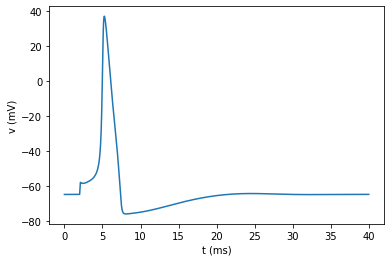

In [32]:
plt.figure()
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

<h2>Step 8: Saving and loading results</h2>

<h3>CSV</h3><p>The <tt>csv</tt> (comma separated variables) file format is widely used for data interchange, and can be used to transfer data to MATLAB, Excel, etc without writing any special conversion code.</p><p>(Many Python distributions provide the <tt>pandas</tt> module which can do the same using a slightly simpler interface, but the code below works in all versions of Python... an example of reading CSV using pandas is shown below.)

Python provides the <a href="https://docs.python.org/3/library/csv.html"><tt>csv</tt></a> module to simplify reading and writing <tt>csv</tt> files. We load it via:

In [33]:
import csv

<h4>Writing</h4>

In [34]:
with open('data.csv', 'w') as f:
    csv.writer(f).writerows(zip(t, v))

You should now have a <tt>data.csv</tt> file. Try loading it in your favorite spreadsheet.

To write additional variables (as columns) to the CSV file, just add them inside the <tt>zip</tt>; e.g. <tt>zip(t, v1, v2, ca1)</tt>.

<h4>Reading</h4>

In [35]:
with open('data.csv') as f:
    reader = csv.reader(f)
    tnew, vnew = zip(*[[float(val) for val in row] for row in reader if row])

The argument to the <tt>zip</tt> is a nested list comprehension; the zip and the asterisk together effectively transpose the data turning it from a list of (t, v) pairs into a list of t values and a list of v values. For loading more variables, the right hand side of the last line is unchanged; all that changes is that the variables need to be listed on the left; e.g. <tt>tnew, vnew, canew = zip(...)</tt>

We can plot our newly loaded data (here with matplotlib) to see that it is the same as before:

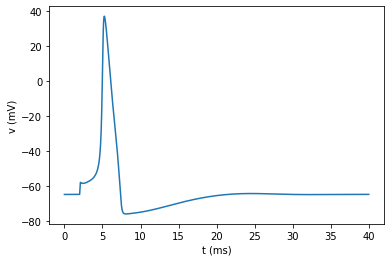

In [36]:
plt.figure()
plt.plot(tnew, vnew)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

<b>Reading and plotting using <tt>plotnine</tt> and <tt>pandas</tt>:</b>

The modules <tt>plotnine</tt> and <tt>pandas</tt> are key components of the Python data science ecosystem. We can use them to work with our NEURON data, but they may have to be installed separately.

First, we'll load the modules. It is common to use shortened names for the modules, but this is not necessary:

In [37]:
import plotnine as p9
import pandas as pd

We can load the data:

In [38]:
data = pd.read_csv('data.csv', header=None, names=['t', 'v'])

(If the CSV file had a header row identifying the columns, then <tt>pd.read_csv</tt> would have handled the names automatically and we would not have had to specify the last two arguments above.)

And now plot with <tt>plotnine</tt>'s version of <tt>ggplot</tt>. This function provides an implementation of Wilkinson's <a href="http://doi.org/10.1007/0-387-28695-0">Grammar of Graphics</a>; as such, the interface is essentially identical to the R function of the same name. 

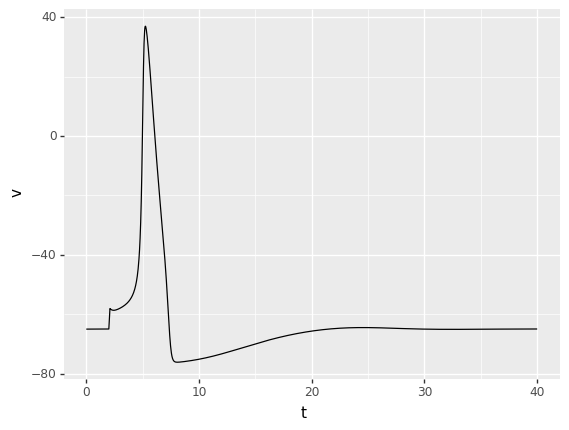

In [39]:
g = (p9.ggplot(data, p9.aes(x='t', y='v')) + p9.geom_path()).draw()

<h3>JSON</h3><p>JSON is used for structured data interchange. It is a newer but widely used format and libraries for reading and writing JSON exist for most programming languages.</p><p>Python provides the <a href="https://docs.python.org/3/library/json.html">json</a> module to simplify reading and writing JSON files. We load it via:</p>

In [40]:
import json

<h4>Writing</h4>

In [41]:
with open('data.json', 'w') as f:
    json.dump({'t': list(t), 'v': list(v)}, f, indent=4)

Here we built a dictionary with keys <tt>t</tt> and <tt>v</tt>, and stored their values as a list. Since JSON is a language-independent format, it does not have a concept of NEURON Vectors, which is why we had to create a list copy of them before saving. The <tt>indent=4</tt> argument is optional, but indents the output to make it more human-readable (at the cost of a larger file size).

<h4>Reading</h4>

In [42]:
with open('data.json') as f:
    data = json.load(f)
tnew = data['t']
vnew = data['v']

As for <tt>csv</tt>, we plot the newly loaded data to show that it is the same as the original:

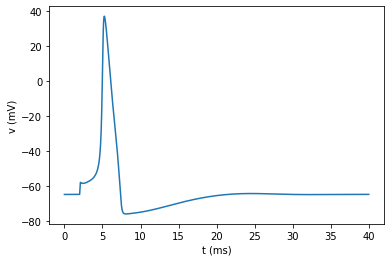

In [43]:
plt.figure()
plt.plot(tnew, vnew)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

<h3>Pickles</h3><p>Pickles are a Python-specific data exchange format.</p><p>Python provides the <a href="https://docs.python.org/3/library/pickle.html">pickle</a> module to read and write pickled files. We load it via:

In [44]:
import pickle

<h4>Writing</h4>

In [45]:
with open('data.p', 'wb') as f:
    pickle.dump({'t': t, 'v': v}, f)

This is slightly cleaner than the JSON solution above because it is Python specific and therefore able to explicitly encode NEURON Vector objects.

<h4>Reading</h4>

In [46]:
with open('data.p', 'rb') as f:
    data = pickle.load(f)
tnewp = data['t']
vnewp = data['v']

Pickles in Python 3 are by default binary files, so we have to specify write and read flags of <tt>wb</tt> and <tt>rb</tt> respectively. We use a different variable name here than before simply to indicate that what is loaded in has type

In [47]:
type(tnewp)

hoc.HocObject

and in particular is a NEURON <tt>Vector</tt>:

In [48]:
tnewp.hname()

'Vector[2]'

Unlike the other solutions provided, which construct regular Python lists:

In [49]:
type(tnew)

list

This is a minor distinction though, as we've already seen <tt>list(vec)</tt> copies a Vector <tt>vec</tt> into a new list. Using `h.Vector(old_list)` makes a NEURON Vector that is a copy of `old_list`.

As before, plotting suggests that we have successfully loaded in the data:

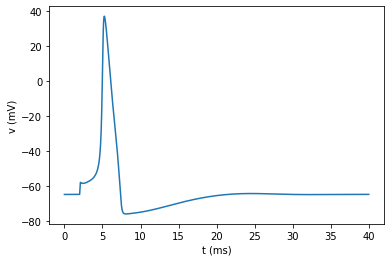

In [50]:
plt.figure()
plt.plot(tnewp, vnewp)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()